# [第8章: ニューラルネット](https://nlp100.github.io/ja/ch08.html)
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

## [70. 単語ベクトルの和による特徴量](https://nlp100.github.io/ja/ch08.html#70-%E5%8D%98%E8%AA%9E%E3%83%99%E3%82%AF%E3%83%88%E3%83%AB%E3%81%AE%E5%92%8C%E3%81%AB%E3%82%88%E3%82%8B%E7%89%B9%E5%BE%B4%E9%87%8F)
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例$x_i$の特徴ベクトル$\boldsymbol{x}_i$を並べた行列$X$と，正解ラベルを並べた行列（ベクトル）$Y$を作成したい．

$$
X = \begin{pmatrix} 
  \boldsymbol{x}_1 \\ 
  \boldsymbol{x}_2 \\ 
  \dots \\ 
  \boldsymbol{x}_n \\ 
\end{pmatrix} \in \mathbb{R}^{n \times d},
Y = \begin{pmatrix} 
  y_1 \\ 
  y_2 \\ 
  \dots \\ 
  y_n \\ 
\end{pmatrix} \in \mathbb{N}^{n}
$$

ここで，$n$は学習データの事例数であり，$\boldsymbol{x}_i \in \mathbb{R}^d$と$y_i \in \mathbb{N}$はそれぞれ，$i \in \{1, \dots, n\}$番目の事例の特徴量ベクトルと正解ラベルを表す．
なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．$\mathbb{N}_{<4}$で$4$未満の自然数（$0$を含む）を表すことにすれば，任意の事例の正解ラベル$y_i$は$y_i \in \mathbb{N}_{<4}$で表現できる．
以降では，ラベルの種類数を$L$で表す（今回の分類タスクでは$L=4$である）．

$i$番目の事例の特徴ベクトル$\boldsymbol{x}_i$は，次式で求める．

$$
\boldsymbol{x}_i = \frac{1}{T_i} \sum_{t=1}^{T_i} \mathrm{emb}(w_{i,t})
$$

ここで，$i$番目の事例は$T_i$個の（記事見出しの）単語列$(w_{i,1}, w_{i,2}, \dots, w_{i,T_i})$から構成され，$\mathrm{emb}(w) \in \mathbb{R}^d$は単語$w$に対応する単語ベクトル（次元数は$d$）である．すなわち，$i$番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものが$\boldsymbol{x}_i$である．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．$300$次元の単語ベクトルを用いたので，$d=300$である．

$i$番目の事例のラベル$y_i$は，次のように定義する．

$$
y_i = \begin{cases}
0 & (\mbox{記事}x_i\mbox{が「ビジネス」カテゴリの場合}) \\
1 & (\mbox{記事}x_i\mbox{が「科学技術」カテゴリの場合}) \\
2 & (\mbox{記事}x_i\mbox{が「エンターテイメント」カテゴリの場合}) \\
3 & (\mbox{記事}x_i\mbox{が「健康」カテゴリの場合}) \\
\end{cases}
$$

なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．
* 学習データの特徴量行列: $X_{\rm train} \in \mathbb{R}^{N_t \times d}$
* 学習データのラベルベクトル: $Y_{\rm train} \in \mathbb{N}^{N_t}$
* 検証データの特徴量行列: $X_{\rm valid} \in \mathbb{R}^{N_v \times d}$
* 検証データのラベルベクトル: $Y_{\rm valid} \in \mathbb{N}^{N_v}$
* 評価データの特徴量行列: $X_{\rm test} \in \mathbb{R}^{N_e \times d}$
* 評価データのラベルベクトル: $Y_{\rm test} \in \mathbb{N}^{N_e}$

なお，$N_t, N_v, N_e$はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [1]:
!ls Input/GoogleNews-vectors-negative300.bin

Input/GoogleNews-vectors-negative300.bin


In [2]:
!ls Output/Chapter06/*.txt | grep -v feature.txt

Output/Chapter06/test.txt
Output/Chapter06/train.txt
Output/Chapter06/valid.txt


In [3]:
from gensim.models.keyedvectors import KeyedVectors
import numpy as np

In [4]:
%%time
wv = KeyedVectors.load_word2vec_format("Input/GoogleNews-vectors-negative300.bin", binary=True)
labels = ["b", "t", "e", "m"]

CPU times: user 21.5 s, sys: 4.3 s, total: 25.8 s
Wall time: 25.8 s


In [5]:
def save_features(file_type: str):
    if file_type != "train" and file_type != "valid" and file_type != "test":
        raise ValueError("file_type:%s" % file_type)

    in_path = "Output/Chapter06/%s.txt" % file_type
    out_paths = ("Output/Chapter08/x_%s.npy" % file_type,
                 "Output/Chapter08/y_%s.npy" % file_type)
    x, y = [], []

    with open(in_path) as f:
        for line in f:
            elements = line.replace("\n", "").split("\t")
            label, words = elements[0], elements[1].split()
            wvs = [wv[word] if word in wv else np.zeros(300) for word in words]
            x.append(sum(wvs) / len(words))
            y.append(labels.index(label))

    np.save(out_paths[0], np.array(x))
    np.save(out_paths[1], np.array(y))

In [6]:
%%time
save_features("train")
save_features("valid")
save_features("test")

CPU times: user 680 ms, sys: 96 ms, total: 776 ms
Wall time: 784 ms


## [71. 単層ニューラルネットワークによる予測](https://nlp100.github.io/ja/ch08.html#71-%E5%8D%98%E5%B1%A4%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E3%81%AB%E3%82%88%E3%82%8B%E4%BA%88%E6%B8%AC)
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

$$
\hat{\boldsymbol{y}}_1 = {\rm softmax}(\boldsymbol{x}_1 W), \\
\hat{Y} = {\rm softmax}(X_{[1:4]} W)
$$

ただし，${\rm softmax}$はソフトマックス関数，$X_{[1:4]} \in \mathbb{R}^{4 \times d}$は特徴ベクトル$\boldsymbol{x}_1, \boldsymbol{x}_2, \boldsymbol{x}_3, \boldsymbol{x}_4$を縦に並べた行列である．

$$
X_{[1:4]} = \begin{pmatrix} 
  \boldsymbol{x}_1 \\ 
  \boldsymbol{x}_2 \\ 
  \boldsymbol{x}_3 \\ 
  \boldsymbol{x}_4 \\ 
\end{pmatrix}
$$

行列$W \in \mathbb{R}^{d \times L}$は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，$\hat{\boldsymbol{y}}_1 \in \mathbb{R}^L$は未学習の行列$W$で事例$x_1$を分類したときに，各カテゴリに属する確率を表すベクトルである．
同様に，$\hat{Y} \in \mathbb{R}^{n \times L}$は，学習データの事例$x_1, x_2, x_3, x_4$について，各カテゴリに属する確率を行列として表現している．

In [7]:
from scipy.special import softmax

In [8]:
x_train = np.load("Output/Chapter08/x_train.npy")
x_train.shape

(10684, 300)

In [9]:
np.random.seed(71)
W = np.random.rand(300, len(labels))
W.shape

(300, 4)

In [10]:
y1_hat = softmax(np.dot(x_train[0], W))
y1_hat

array([0.42920103, 0.15615603, 0.20122837, 0.21341457])

In [11]:
Y_hat = softmax(np.dot(x_train[0:4], W), axis=1)
Y_hat

array([[0.42920103, 0.15615603, 0.20122837, 0.21341457],
       [0.32091756, 0.27438051, 0.13843634, 0.26626559],
       [0.3609244 , 0.27313285, 0.14794164, 0.21800111],
       [0.31986883, 0.21250531, 0.2104081 , 0.25721776]])

## [72. 損失と勾配の計算](https://nlp100.github.io/ja/ch08.html#72-%E6%90%8D%E5%A4%B1%E3%81%A8%E5%8B%BE%E9%85%8D%E3%81%AE%E8%A8%88%E7%AE%97)
学習データの事例$x_1$と事例集合$x_1, x_2, x_3, x_4$に対して，クロスエントロピー損失と，行列$W$に対する勾配を計算せよ．なお，ある事例$x_i$に対して損失は次式で計算される．

$$
l_i = - \log [\mbox{事例}x_i\mbox{が}y_i\mbox{に分類される確率}]
$$

ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [12]:
y_train = np.load("Output/Chapter08/y_train.npy")
y_train.shape

(10684,)

In [13]:
l1 = -1.0 * np.log(y1_hat[y_train[0]])
l1

0.8458298750279626

In [14]:
L = -1.0 * sum([np.log(Y_hat[i][y_train[i]]) for i in range(4)]) / 4.0
L

1.0745000866864252

In [15]:
g1 = np.dot(x_train[0].reshape(300, 1), (y1_hat - y_train[0]).reshape(1, 4))
g1.shape

(300, 4)

In [16]:
G = np.dot(x_train[0:4].T, Y_hat - y_train[0:4])
G.shape

(300, 4)

## [73. 確率的勾配降下法による学習](https://nlp100.github.io/ja/ch08.html#73-%E7%A2%BA%E7%8E%87%E7%9A%84%E5%8B%BE%E9%85%8D%E9%99%8D%E4%B8%8B%E6%B3%95%E3%81%AB%E3%82%88%E3%82%8B%E5%AD%A6%E7%BF%92)
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列$W$を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [17]:
import random
import torch

In [18]:
random.seed(73)
np.random.seed(73)
torch.manual_seed(73)

In [19]:
class NewsAggregatorDataset(torch.utils.data.Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        self.x_data = torch.from_numpy(x.astype(np.float32))
        self.y_data = torch.from_numpy(y.astype(np.int64))

    def __len__(self):
        return self.y_data.shape[0]

    def __getitem__(self, idx):
        x_in = self.x_data[idx]
        y = self.y_data[idx]
        return x_in, y

    def to(self, device: torch.device):
        self.x_data.to(device)
        self.y_data.to(device)

In [20]:
class Network73(torch.nn.Module):
    def __init__(self):
        super(Network73, self).__init__()

        self.fc = torch.nn.Sequential(
            # (batch,300) -> (batch,4)
            torch.nn.Linear(in_features=300,
                            out_features=4,
                            bias=False),
        )
        self.log_softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # (batch,300) -> (batch,4)
        x = self.fc(x)
        return self.log_softmax(x)

In [21]:
dataset_train = NewsAggregatorDataset(x_train, y_train)
loader_train = torch.utils.data.DataLoader(dataset_train,
                                           batch_size=1,
                                           shuffle=True)
epoch, print_interval, lr = 30, 5, 0.05

In [22]:
%%time
network = Network73()

for e in range(1, epoch+1):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(network.parameters(), lr=lr)
    loss_sum = 0.0
    correct_sum = 0

    for x_in, y in loader_train:
        network.zero_grad()
        x_out = network(x_in)
        loss = criterion(x_out, y)
        loss.backward()
        optimizer.step()

        if e % print_interval == 0:
            loss_sum += loss.item() * x_in.shape[0]
            x_pred = torch.argmax(x_out, dim=1)
            correct_sum += int(torch.sum(x_pred==y))

    if e % print_interval == 0:
        accuracy = 100.0 * correct_sum / len(dataset_train)
        args = (e, epoch, loss_sum, accuracy)
        print_str = "Epoch:%d/%d,Loss:%.3f,Accuracy:%.2f%%"
        print(print_str % args)

Epoch:5/30,Loss:3493.017,Accuracy:89.08%
Epoch:10/30,Loss:3202.702,Accuracy:89.98%
Epoch:15/30,Loss:3068.851,Accuracy:90.39%
Epoch:20/30,Loss:2990.789,Accuracy:90.42%
Epoch:25/30,Loss:2940.080,Accuracy:90.63%
Epoch:30/30,Loss:2899.830,Accuracy:90.75%
CPU times: user 2min 32s, sys: 11.1 s, total: 2min 43s
Wall time: 2min 38s


## [74. 正解率の計測](https://nlp100.github.io/ja/ch08.html#74-%E6%AD%A3%E8%A7%A3%E7%8E%87%E3%81%AE%E8%A8%88%E6%B8%AC)
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [23]:
correct_sum = 0

for x_in, y in loader_train:
    x_out = network(x_in)
    x_pred = torch.argmax(x_out, dim=1)
    correct_sum += int(torch.sum(x_pred==y))

accuracy = 100.0 * correct_sum / len(dataset_train)
print("Training Accuracy:%.2f%%" % accuracy)

Training Accuracy:90.81%


In [24]:
x_valid = np.load("Output/Chapter08/x_valid.npy")
y_valid = np.load("Output/Chapter08/y_valid.npy")
dataset_valid = NewsAggregatorDataset(x_valid, y_valid)
loader_valid = torch.utils.data.DataLoader(dataset_valid,
                                           batch_size=1,
                                           shuffle=True)

In [25]:
correct_sum = 0

for x_in, y in loader_valid:
    x_out = network(x_in)
    x_pred = torch.argmax(x_out, dim=1)
    correct_sum += int(torch.sum(x_pred==y))

accuracy = 100.0 * correct_sum / len(dataset_valid)
print("Validation Accuracy:%.2f%%" % accuracy)

Validation Accuracy:89.67%


## [75. 損失と正解率のプロット](https://nlp100.github.io/ja/ch08.html#75-%E6%90%8D%E5%A4%B1%E3%81%A8%E6%AD%A3%E8%A7%A3%E7%8E%87%E3%81%AE%E3%83%97%E3%83%AD%E3%83%83%E3%83%88)
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [27]:
random.seed(75)
np.random.seed(75)
torch.manual_seed(75)

In [28]:
%matplotlib inline

In [29]:
sns.set(style="darkgrid", context="notebook", palette="muted")

In [30]:
network = Network73()
result = {"Epoch" : [],
          "Type" : [],
          "Loss" : [],
          "Accuracy" : []}

for e in tqdm(range(1, epoch+1)):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(network.parameters(), lr=lr)
    loss_sum = 0.0
    correct_sum = 0

    for x_in, y in loader_train:
        network.zero_grad()
        x_out = network(x_in)
        loss = criterion(x_out, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y))

    accuracy = 100.0 * correct_sum / len(dataset_train)
    result["Epoch"].append(e)
    result["Type"].append("Training")
    result["Loss"].append(loss_sum)
    result["Accuracy"].append(accuracy)

    loss_sum = 0.0
    correct_sum = 0

    for x_in, y in loader_valid:
        network.zero_grad()
        x_out = network(x_in)
        loss = criterion(x_out, y)

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y))

    accuracy = 100.0 * correct_sum / len(dataset_valid)
    result["Epoch"].append(e)
    result["Type"].append("Validation")
    result["Loss"].append(loss_sum)
    result["Accuracy"].append(accuracy)

100%|██████████| 30/30 [03:07<00:00,  6.26s/it]


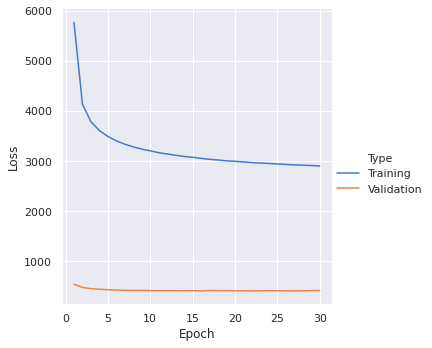

In [31]:
sns.relplot(x="Epoch",
            y="Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result))

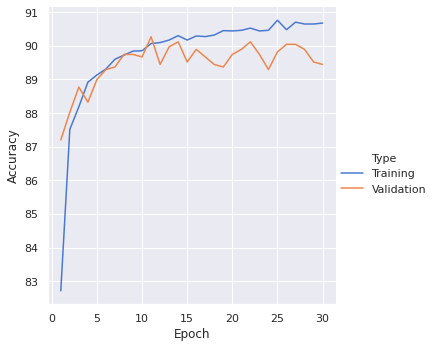

In [32]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result))

## [76. チェックポイント](https://nlp100.github.io/ja/ch08.html#76-%E3%83%81%E3%82%A7%E3%83%83%E3%82%AF%E3%83%9D%E3%82%A4%E3%83%B3%E3%83%88)
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [33]:
random.seed(76)
np.random.seed(76)
torch.manual_seed(76)

In [34]:
%%time
network = Network73()
loss_path = "Output/Chapter08/76_loss.log"
accuracy_path = "Output/Chapter08/76_accuracy.log"

with open(loss_path, "w") as f_loss, open(accuracy_path, "w") as f_accuracy:
    for e in tqdm(range(1, epoch+1)):
        criterion = torch.nn.NLLLoss()
        optimizer = torch.optim.SGD(network.parameters(), lr=lr)
        loss_sum = 0.0
        correct_sum = 0

        for x_in, y in loader_train:
            network.zero_grad()
            x_out = network(x_in)
            loss = criterion(x_out, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item() * x_in.shape[0]
            x_pred = torch.argmax(x_out, dim=1)
            correct_sum += int(torch.sum(x_pred==y))

        torch.save(network.fc[0].weight, "Output/Chapter08/76_w_epoch%d.pt" % e)
        f_loss.write("[Epoch:%d/%d]\n" % (e, epoch))
        f_loss.write("%.3f\n\n" % loss_sum)
        accuracy = 100.0 * correct_sum / len(dataset_train)
        f_accuracy.write("[Epoch:%d/%d]\n" % (e, epoch))
        f_accuracy.write("%.2f%%\n\n" % accuracy)

100%|██████████| 30/30 [02:59<00:00,  5.98s/it]

CPU times: user 2min 54s, sys: 10.6 s, total: 3min 4s
Wall time: 2min 59s


## [77. ミニバッチ化](https://nlp100.github.io/ja/ch08.html#77-%E3%83%9F%E3%83%8B%E3%83%90%E3%83%83%E3%83%81%E5%8C%96)
問題76のコードを改変し，$B$事例ごとに損失・勾配を計算し，行列$W$の値を更新せよ（ミニバッチ化）．$B$の値を$1, 2, 4, 8, \dots$と変化させながら，1エポックの学習に要する時間を比較せよ．

## [78. GPU上での学習](https://nlp100.github.io/ja/ch08.html#78-gpu%E4%B8%8A%E3%81%A7%E3%81%AE%E5%AD%A6%E7%BF%92)
問題77のコードを改変し，GPU上で学習を実行せよ．

## [79. 多層ニューラルネットワーク](https://nlp100.github.io/ja/ch08.html#79-%E5%A4%9A%E5%B1%A4%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF)
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．